<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/lstm/ml/bilstm_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Optional: install dependencies if running in a fresh environment
%pip install -q pandas scikit-learn tensorflow matplotlib seaborn joblib

## Imports and Dependencies

In [2]:
import json
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


## Configuration and Paths

In [3]:
# Mount Google Drive (if running in Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
    print("Google Drive mounted successfully!")
except ImportError:
    DRIVE_MOUNTED = False
    print("Not running in Google Colab. Using local paths.")

Mounted at /content/drive
Google Drive mounted successfully!


In [4]:
from pathlib import Path

# Paths and basic settings
# Set base directory based on environment
if DRIVE_MOUNTED:
    # Google Drive path - Update this to match your Google Drive folder structure
    BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/sinxdetect")
    DATA_DIR = BASE_DIR / 'dataset'
    MODEL_DIR = BASE_DIR / 'ml/models/bilstm_sinhala'
else:
    # Local paths
    DATA_DIR = Path('dataset/final')
    MODEL_DIR = Path('models/bilstm_sinhala')

assert DATA_DIR.exists(), f"Dataset directory not found at {DATA_DIR.absolute()}"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = DATA_DIR / 'train.jsonl'
VAL_PATH = DATA_DIR / 'val.jsonl'
TEST_PATH = DATA_DIR / 'test.jsonl'

SEED = 42
MAX_TOKENS = 30000  # vocab size for TextVectorization
SEQ_LEN = 400       # truncate/pad length (tune as needed)
BATCH_SIZE = 64
EPOCHS = 2  # Reduced from 3 to prevent overfitting
EMBED_DIM = 64  # Reduced from 128
LSTM_UNITS = 64  # Reduced from 128

tf.random.set_seed(SEED)
np.random.seed(SEED)

assert TRAIN_PATH.exists(), f'Missing train.jsonl at {TRAIN_PATH.absolute()}'
assert VAL_PATH.exists(), f'Missing val.jsonl at {VAL_PATH.absolute()}'
assert TEST_PATH.exists(), f'Missing test.jsonl at {TEST_PATH.absolute()}'

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Model directory: {MODEL_DIR.absolute()}")
print(f"Train path: {TRAIN_PATH.absolute()}")
print(f"Val path: {VAL_PATH.absolute()}")
print(f"Test path: {TEST_PATH.absolute()}")

Data directory: /content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset
Model directory: /content/drive/MyDrive/Colab Notebooks/sinxdetect/ml/models/bilstm_sinhala
Train path: /content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset/train.jsonl
Val path: /content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset/val.jsonl
Test path: /content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset/test.jsonl


## Data Loading

In [5]:
# Load JSONL files into DataFrames
def read_jsonl(path: Path) -> pd.DataFrame:
    return pd.read_json(path, lines=True)

train_df = read_jsonl(TRAIN_PATH)
val_df = read_jsonl(VAL_PATH)
test_df = read_jsonl(TEST_PATH)

for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    print(f'{name}: {len(df):,} rows | columns: {list(df.columns)}')

train_df.head()

train: 77,788 rows | columns: ['text', 'label', 'meta', 'model']
val: 9,045 rows | columns: ['text', 'label', 'meta']
test: 13,046 rows | columns: ['text', 'label', 'meta']


,text,label,meta,model
0,ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
1,ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
2,(අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
3,(ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
4,(ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN


## Data Preprocessing

In [6]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

def encode_labels(df: pd.DataFrame) -> np.ndarray:
    return label_encoder.transform(df['label'])

y_train = encode_labels(train_df)
y_val = encode_labels(val_df)
y_test = encode_labels(test_df)

NUM_CLASSES = len(label_encoder.classes_)
print('Classes:', label_encoder.classes_)

Classes: ['AI' 'HUMAN']


In [7]:
# Build TextVectorization for Sinhala text
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=SEQ_LEN,
    standardize='lower_and_strip_punctuation'
)

# Adapt on training text only
text_vectorizer.adapt(train_df['text'].values)

def make_dataset(texts: pd.Series, labels: np.ndarray, training: bool) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((texts.values, labels))
    if training:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds.map(lambda x, y: (text_vectorizer(x), y))

train_ds = make_dataset(train_df['text'], y_train, training=True)
val_ds = make_dataset(val_df['text'], y_val, training=False)
test_ds = make_dataset(test_df['text'], y_test, training=False)

for batch_x, batch_y in train_ds.take(1):
    print('Vectorized batch shape:', batch_x.shape, '| labels shape:', batch_y.shape)

Vectorized batch shape: (64, 400) | labels shape: (64,)


## Model Architecture

The network uses an embedding layer initialized randomly, followed by a bidirectional LSTM stack and dropout regularization. The output layer is a dense softmax over the label set.

In [8]:
def build_model():
    """
    Build BiLSTM model with aggressive regularization to prevent overfitting
    """
    from tensorflow.keras import regularizers

    inputs = tf.keras.Input(shape=(None,), dtype=tf.int64, name='tokens')

    # Embedding layer (trainable=False initially to prevent overfitting)
    x = tf.keras.layers.Embedding(
        MAX_TOKENS,
        EMBED_DIM,
        mask_zero=True,
        embeddings_regularizer=regularizers.l2(1e-4),  # L2 regularization
        trainable=False  # Freeze embeddings initially
    )(inputs)

    # Dropout on embeddings
    x = tf.keras.layers.Dropout(0.3)(x)

    # First BiLSTM layer with recurrent dropout
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            LSTM_UNITS,
            return_sequences=True,
            dropout=0.3,  # Input dropout
            recurrent_dropout=0.2,  # Recurrent dropout
            kernel_regularizer=regularizers.l2(1e-4)
        )
    )(x)

    # Dropout after first LSTM
    x = tf.keras.layers.Dropout(0.4)(x)

    # Second BiLSTM layer (smaller, with dropout)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            LSTM_UNITS // 2,
            dropout=0.3,
            recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(1e-4)
        )
    )(x)

    # Dropout after second LSTM
    x = tf.keras.layers.Dropout(0.5)(x)

    # Smaller dense layer with L2 regularization
    x = tf.keras.layers.Dense(
        32,  # Reduced from 128
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    )(x)

    # Final dropout before output
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='bilstm_classifier_regularized')

    # Compile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Reduced from 2e-4
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()



Model: "bilstm_classifier_regularized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │  1,920,000 │ tokens[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 64)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ tokens[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     66,048 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 128) │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout_1[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         66 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,029,410 (7.74 MB)

 Trainable params: 109,410 (427.38 KB)

 Non-trainable params: 1,920,000 (7.32 MB)

## Model Training

In [9]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODEL_DIR / 'checkpoint.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=1,  # Reduced from 2 - stop after 1 epoch of no improvement
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when validation stops improving
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/2
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7379 - loss: 0.5769
Epoch 1: val_accuracy improved from -inf to 0.95202, saving model to /content/drive/MyDrive/Colab Notebooks/sinxdetect/ml/models/bilstm_sinhala/checkpoint.keras
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 4705s 4s/step - accuracy: 0.7380 - loss: 0.5768 - val_accuracy: 0.9520 - val_loss: 0.2063 - learning_rate: 1.0000e-04
Epoch 2/2
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9009 - loss: 0.3185
Epoch 2: val_accuracy improved from 0.95202 to 0.95622, saving model to /content/drive/MyDrive/Colab Notebooks/sinxdetect/ml/models/bilstm_sinhala/checkpoint.keras
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 4715s 4s/step - accuracy: 0.9009 - loss: 0.3185 - val_accuracy: 0.9562 - val_loss: 0.1823 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


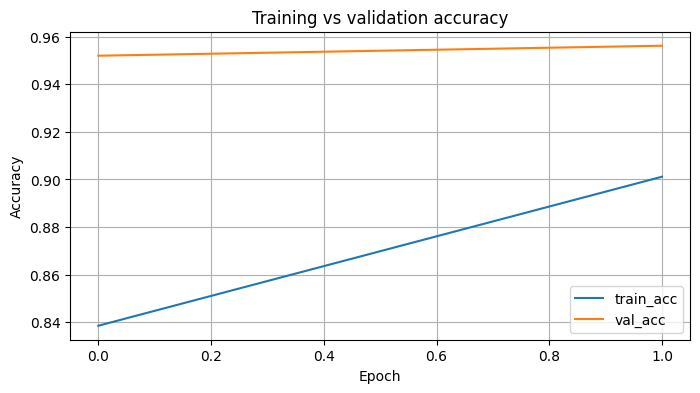

In [10]:
# Plot training curves
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

In [11]:
# Evaluate on the held-out test set
test_probs = model.predict(test_ds)
test_pred = np.argmax(test_probs, axis=1)

print('Test accuracy:', (test_pred == y_test).mean())
print('Classification report')
print(classification_report(y_test, test_pred, target_names=label_encoder.classes_))

204/204 ━━━━━━━━━━━━━━━━━━━━ 130s 630ms/step
Test accuracy: 0.8718381112984823
Classification report
              precision    recall  f1-score   support

          AI       0.90      0.81      0.85      6065
       HUMAN       0.85      0.93      0.89      6981

    accuracy                           0.87     13046
   macro avg       0.88      0.87      0.87     13046
weighted avg       0.87      0.87      0.87     13046



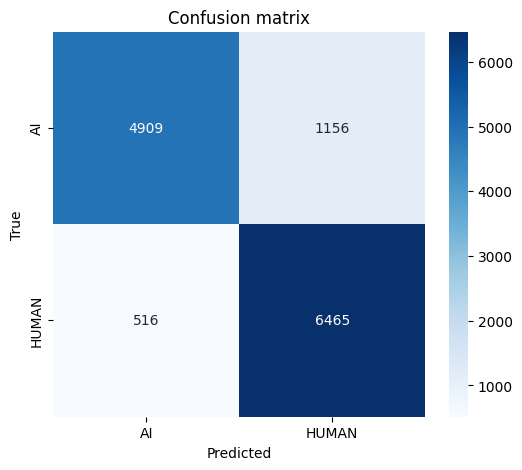

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

Classes: ['AI' 'HUMAN']
AI index: 0, HUMAN index: 1
Using positive class: AI (index 0)
Probability range: [0.000698, 0.997406]
Mean prob when true=AI:    0.781959
Mean prob when true=HUMAN: 0.150776
Unique probability values: 13033
Extreme probabilities (<0.01 or >0.99): 1708/13046
Evaluating on: 13046 samples
Test accuracy: 0.8718


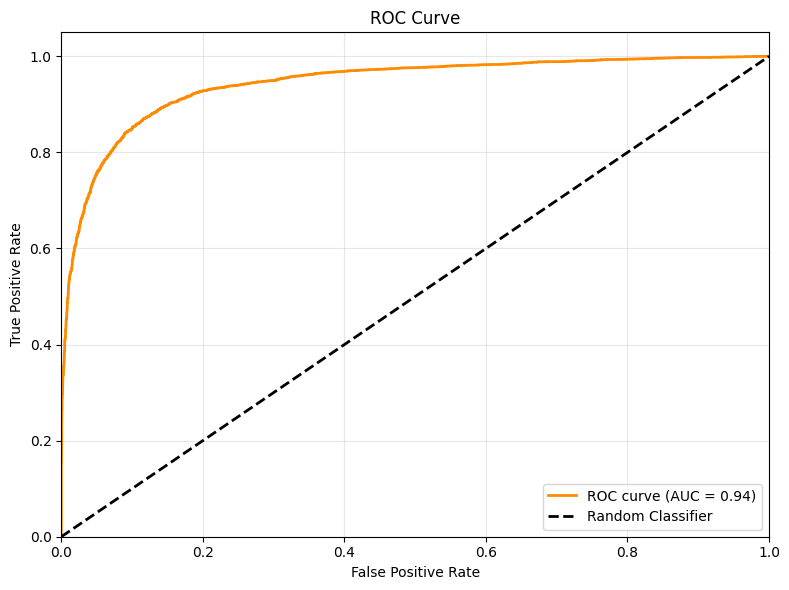

In [13]:
# ROC Curve - FIXED VERSION
# For multi-class ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

# Ensure test_probs is a numpy array (convert from tensor if needed)
if hasattr(test_probs, 'numpy'):
    test_probs_np = test_probs.numpy()
else:
    test_probs_np = np.array(test_probs)

# Ensure probabilities are properly normalized (should already be from softmax)
test_probs_np = test_probs_np / test_probs_np.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))

if NUM_CLASSES == 2:
    # Binary classification
    # CRITICAL FIX: Determine which class is AI
    # LabelEncoder sorts alphabetically, so AI=0, HUMAN=1
    ai_class_idx = label_encoder.transform(['AI'])[0]
    human_class_idx = label_encoder.transform(['HUMAN'])[0]

    print(f"Classes: {label_encoder.classes_}")
    print(f"AI index: {ai_class_idx}, HUMAN index: {human_class_idx}")

    # Use AI as the positive class
    positive_class_idx = ai_class_idx
    probs_positive = test_probs_np[:, positive_class_idx]

    # Ensure probabilities are in valid range [0, 1]
    probs_positive = np.clip(probs_positive, 0, 1)

    # CRITICAL: Use pos_label to specify AI as positive class
    fpr, tpr, thresholds = roc_curve(
        y_true=y_test,
        y_score=probs_positive,
        pos_label=positive_class_idx  # Explicitly set AI as positive
    )
    roc_auc = auc(fpr, tpr)

    # Diagnostic information
    print(f"Using positive class: {label_encoder.classes_[positive_class_idx]} (index {positive_class_idx})")
    print(f"Probability range: [{probs_positive.min():.6f}, {probs_positive.max():.6f}]")
    print(f"Mean prob when true=AI:    {probs_positive[y_test == ai_class_idx].mean():.6f}")
    print(f"Mean prob when true=HUMAN: {probs_positive[y_test == human_class_idx].mean():.6f}")
    print(f"Unique probability values: {len(np.unique(probs_positive))}")
    print(f"Extreme probabilities (<0.01 or >0.99): {((probs_positive < 0.01) | (probs_positive > 0.99)).sum()}/{len(probs_positive)}")

    # Check if we're evaluating on test set (not train by mistake)
    print(f"Evaluating on: {len(y_test)} samples")
    print(f"Test accuracy: {(test_pred == y_test).mean():.4f}")

    if (test_pred == y_test).mean() == 1.0:
        print("WARNING: 100% accuracy - check if using correct dataset!")

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
else:
    # Multi-class: plot ROC for each class
    colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))
    for i in range(NUM_CLASSES):
        probs_class = np.clip(test_probs_np[:, i], 0, 1)
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_class)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Model Persistence

In [14]:
# Save model and preprocessing assets
model.save(MODEL_DIR / 'saved_model')
joblib.dump(label_encoder, MODEL_DIR / 'label_encoder.joblib')
# Save the vectorizer config to recreate later
vectorizer_config = text_vectorizer.get_config()
vectorizer_weights = text_vectorizer.get_weights()
with open(MODEL_DIR / 'vectorizer_config.json', 'w', encoding='utf-8') as f:
    json.dump(vectorizer_config, f)
np.savez_compressed(MODEL_DIR / 'vectorizer_weights.npz', *vectorizer_weights)
print('Saved to', MODEL_DIR)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Colab Notebooks/sinxdetect/ml/models/bilstm_sinhala/saved_model.

## Inference and Testing

In [ ]:
# Inference helper
def predict_texts(texts):
    if isinstance(texts, str):
        texts = [texts]
    ds = tf.data.Dataset.from_tensor_slices(texts).batch(BATCH_SIZE)
    ds = ds.map(text_vectorizer).prefetch(tf.data.AUTOTUNE)
    probs = model.predict(ds)
    preds = np.argmax(probs, axis=1)
    labels = label_encoder.inverse_transform(preds)
    confidences = np.max(probs, axis=1)
    return list(zip(labels, confidences))

# Test with sample texts from the test set
sample_indices = np.random.choice(len(test_df), 3, replace=False)
sample_texts = test_df.iloc[sample_indices]['text'].tolist()
predictions = predict_texts(sample_texts)

for i, (text, (pred_label, confidence)) in enumerate(zip(sample_texts, predictions)):
    print(f"\nSample {i+1}:")
    print(f"Text: {text[:100]}...")
    print(f"Predicted: {pred_label} (confidence: {confidence:.4f})")
